# 1. Data Exploration
### Lennard Rose 5122737
Start Here, next is Classify_Activities.ipynb

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
import sys

sys.path.append('/content/drive/MyDrive/Colab_Notebooks/Master/SS23_Assignment_3')


In [1]:
%load_ext autoreload
%autoreload 2

## Train Set

I went with the approach of sliding windows. With this I was able to expand my overall number of samples which was very small with growing sequence lengths. For the implementation see the get_SlidingWindow_Dataloader function. I also included all necessary steps to build dataloaders for all possible models (ResNet, CNN, RNN & LSTM) and approaches(Predicting only one timestep (first or last) or all timesteps at once. I also included scaling and train/test splitting which was the first challenge because of the long sequences of different activities. So I first created the sliding windows which I shuffled before I splitted and scaled them. This way I didn´t end up with the validation set just containing data from on activity that made up the last samples.

In [2]:
from sklearn.preprocessing import StandardScaler
from Data import load_dataframes, get_SlidingWindow_Dataloader

df = load_dataframes(labels="start")

dl, dl2, scaler = get_SlidingWindow_Dataloader(df, StandardScaler(), shape_for="lstm", train=True, train_test_split=0.9, batch_size=128)

First insight to the data by getting the mean and variance from the scaler

In [14]:
dl.dataset[0][0][0]

tensor([-1.2238,  0.7630, -0.1897, -0.0394,  0.0194,  0.0031])

In [7]:
scaler.mean_

array([-1.98139090e-01,  3.51014004e+00,  8.63240091e+00,  3.40272706e-04,
        6.37268052e-03,  8.20316155e-03])

In [8]:
scaler.var_

array([3.89979648, 6.08137024, 5.82120331, 0.18487243, 0.18901664,
       0.35840797])

Next I splitted the data by their activities. As you can see below, the data is heavily inbalanced with Activity 1 making up 63% of the training samples.

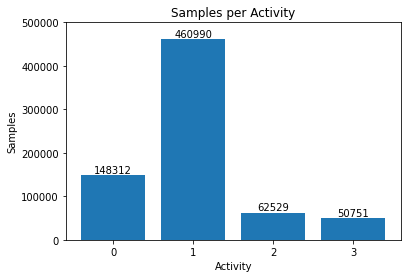

Percentages and count of different activities: 
Activity 0: 148312 - 20% 
Activity 1: 460990 - 63% 
Activity 2: 62529 - 8% 
Activity 3: 50751 - 7% 



In [15]:
from Data import load_dataframes, split_dataframe_by_activity
import matplotlib.pyplot as plt

df_not_balanced = load_dataframes()
df_0, df_1, df_2, df_3 = split_dataframe_by_activity(df_not_balanced)

activities = ['0', '1', '2', '3']
act_counts = [len(df_0),len(df_1),len(df_2),len(df_3)]

fig, ax = plt.subplots()
bar_container = ax.bar(activities, act_counts)
ax.set(xlabel='Activity', ylabel='Samples', title='Samples per Activity', ylim=(0, 500000))
ax.bar_label(bar_container)
plt.show()

print(f"Percentages and count of different activities: \n"
      f"Activity 0: {len(df_0)} - {int(len(df_0)/len(df_not_balanced)*100)}% \n"
      f"Activity 1: {len(df_1)} - {int(len(df_1)/len(df_not_balanced)*100)}% \n"
      f"Activity 2: {len(df_2)} - {int(len(df_2)/len(df_not_balanced)*100)}% \n"
      f"Activity 3: {len(df_3)} - {int(len(df_3)/len(df_not_balanced)*100)}% \n")

I plotted the data for the different activities to get a first look on what I am dealing with. Activity 3 has big amplitudes while Activity 0 looks almost like a straight line.

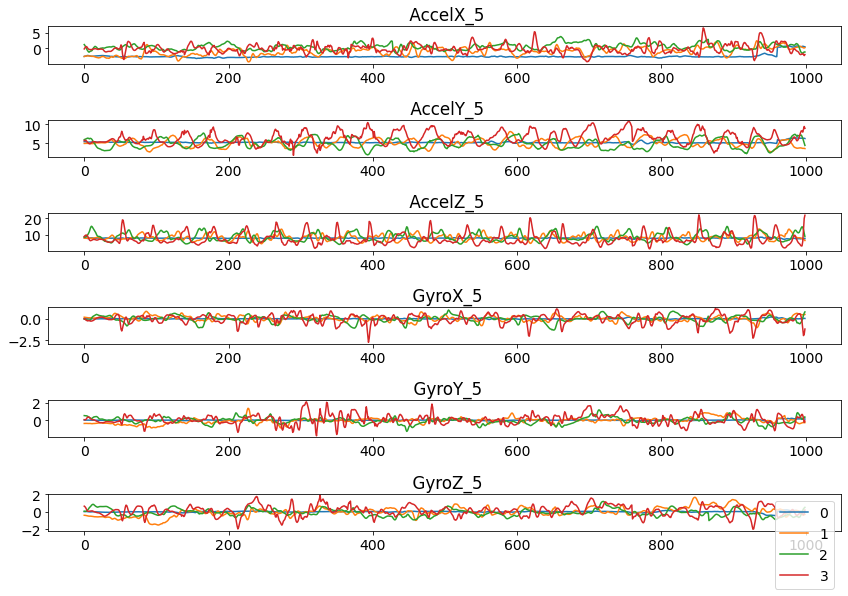

In [16]:
from utils import plot_dataframes

plot_dataframes([df_0, df_1, df_2, df_3], to_sample=1000, steps=False)

I plotted the steps to see how the are distributed and if I can see intervalls with my eyes. I tried all activities as well as combinations of it. Doing this I realized that most start and end steps are very close to each other, in the plot below you cannot see any green or red lines, only yellow ones which are plottet if both are so close to each other.

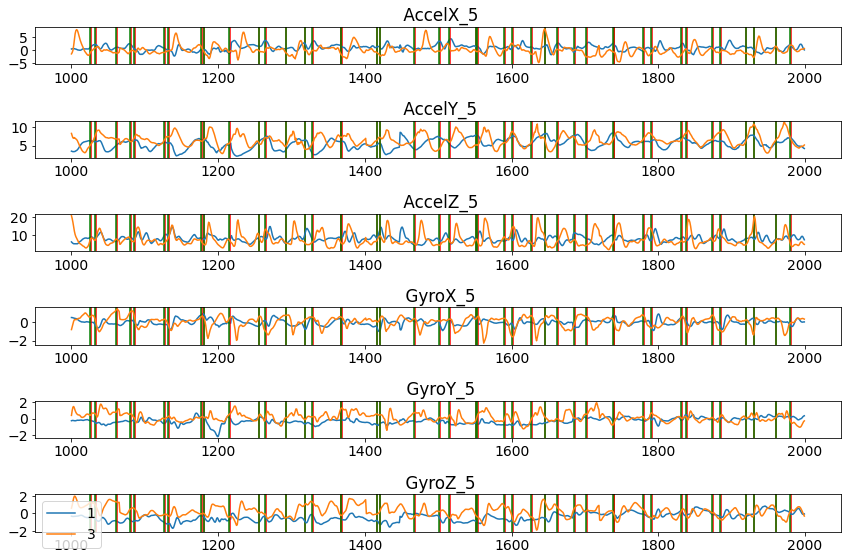

In [22]:
from utils import plot_dataframes

plot_dataframes([df_1, df_3], from_sample=1000, to_sample=2000, steps=True)

By shifting the end steps by one index and see how they allign my my premonition was confirmed. Starts and ends are only one index apart (for the training dataset!) This holds true for over 98% of the dataset. To save on complexity and time ( my main issue during this assignment, doing it alone was not smart) I went on with this heuristic and only trained the models to predict the start steps. I then shifted the indices by one to obtain the end steps.

In [27]:
from Data import load_dataframes
df = load_dataframes(labels="keep")
df = df[["start","end"]]
df['end'] = df['end'].shift(1)
print("Hitting: ")
print(round(len(df[(df['start'] != 0) & (df['end'] != 0)]) / len(df[(df['start'] != 0)]), 3) * 100, "%")
print(round(len(df[(df['start'] != 0) & (df['end'] != 0)]) / len(df[(df['end'] != 0)]), 3) * 100, "%")
print("of all samples")

Hitting: 
98.4 %
98.4 %
of all samples


I also plotted the data to 3D space. Not much to see, maybe if I had colored the step indices in other colors, but it was to much of a hassle for the benefit.

Activity: 0


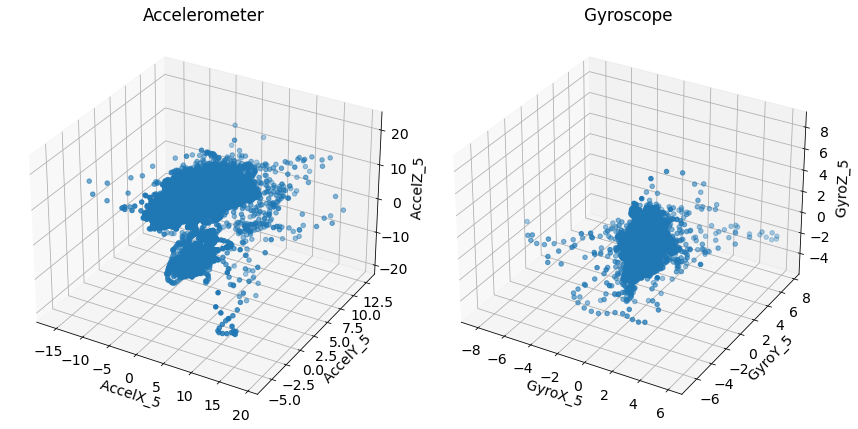

Activity: 1


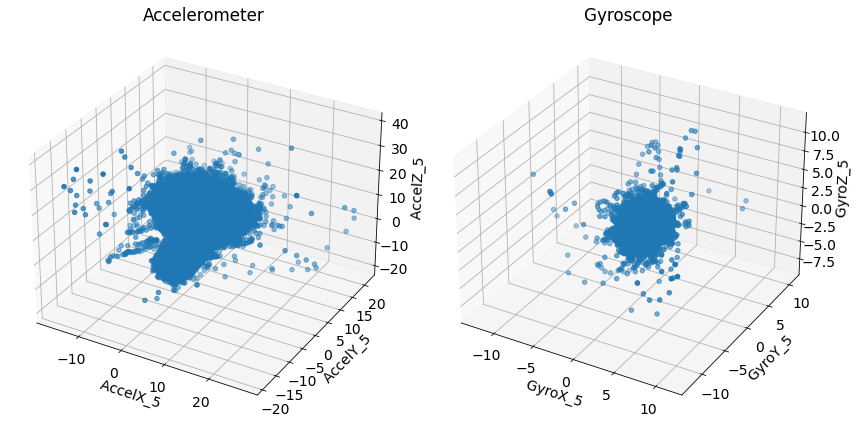

Activity: 2


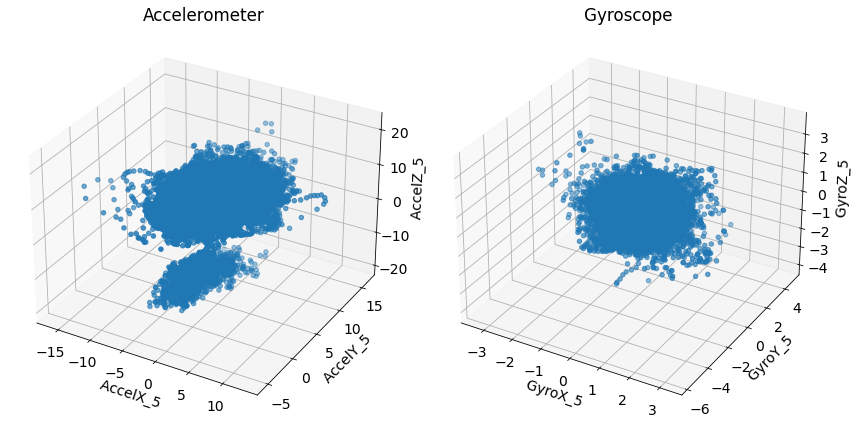

Activity: 3


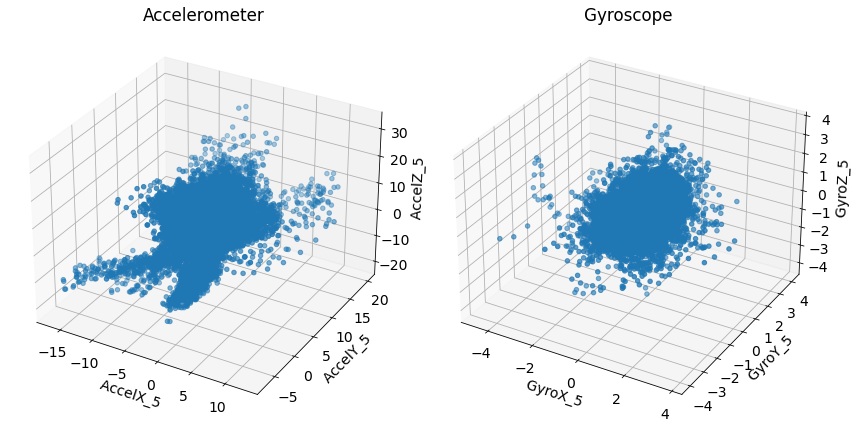

In [23]:
from utils import plot_3d

plot_3d(df_0)
plot_3d(df_1)
plot_3d(df_2)
plot_3d(df_3)

Looking at the individual mean and std values of each activity my first concern, issues with the inbalanced dataset, was mitigated.

In [24]:
import pandas as pd

def show_mean_std(dataframes):
    mean_frames = []
    std_frames = []
    for frame in dataframes:
        mean_frames.append(frame.mean())
        std_frames.append(frame.std())
    print("Mean Values: \n")
    mean_frame = pd.DataFrame(mean_frames)
    mean_frame = mean_frame.drop(columns=[" Activity", "start", "end"])
    display(mean_frame)
    print("Standard Deviations: \n")
    std_frame = pd.DataFrame(std_frames)
    std_frame = std_frame.drop(columns=[" Activity", "start", "end"])
    display(std_frame)

show_mean_std([df_0, df_1, df_2, df_3])

Mean Values: 



,AccelX_5,AccelY_5,AccelZ_5,GyroX_5,GyroY_5,GyroZ_5
0,-0.269630,3.088105,8.356847,-0.006210,0.003461,0.002217
1,-0.202833,3.517647,7.782590,0.005333,0.009514,0.021197
2,-0.232954,3.023855,8.024496,-0.013134,-0.022886,-0.076585
3,-0.594367,3.389965,7.927526,-0.005791,0.022865,0.052453


Standard Deviations: 



,AccelX_5,AccelY_5,AccelZ_5,GyroX_5,GyroY_5,GyroZ_5
0,1.886331,2.234794,2.972358,0.217579,0.281266,0.475916
1,1.938954,2.440693,4.558413,0.473540,0.448869,0.641674
2,1.885185,2.562541,4.642988,0.446110,0.462014,0.577294
3,1.901509,2.314542,5.030638,0.519469,0.529789,0.550509


In the end, I computed the average number of indices between two steps to be able to quickly  evaluate the results.

In [25]:
import glob
import pandas as pd
from scipy.stats import zscore

label_files = glob.glob("./data/**/*.csv.stepMixed")
start_means = []
start_stds = []
end_means = []
end_stds = []
num_stds_tolerance = 2

for labelfile in label_files:

    # load contents
    labelframe = pd.read_csv(labelfile, index_col=None, header=None)
    # split labels to start and end
    starts = labelframe.iloc[:, 0]
    starts = starts.dropna()
    ends = labelframe.iloc[:, 1]
    ends = ends.dropna()
    # calculate mean distance of steps for current dataframe
    starts = starts.sort_values()
    starts = starts.diff()
    starts = starts.dropna()
    # exclude outliers
    zscores = zscore(starts)
    starts_no_outliers = starts[abs(zscores) <= num_stds_tolerance]

    starts_std = starts_no_outliers.std()
    starts_mean = starts_no_outliers.mean()

    ends = ends.sort_values()
    ends = ends.diff()
    ends = ends.dropna()
    # exclude outliers
    zscores = zscore(ends)
    ends_no_outliers = ends[abs(zscores) <= num_stds_tolerance]

    ends_std = ends_no_outliers.std()
    ends_mean = ends_no_outliers.mean()
    # append
    start_means.append(starts_mean)
    start_stds.append(starts_std)
    end_means.append(ends_mean)
    end_stds.append(ends_std)
smeans = sum(start_means) / len(start_means)
sstd = sum(start_stds) / len(start_stds)
emeans = sum(end_means) / len(end_means)
estd = sum(end_stds) / len(start_stds)
print(f"Average number of indices between two stepstarts: {round(smeans)}")
print(f"Standard Deviation stepstarts: {sstd}")
print(f"Average number of indices between two stepends: {round(emeans)}")
print(f"Standard Deviation stepstarts: {estd}")

Average number of indices between two stepstarts: 46
Standard Deviation stepstarts: 6.071364185226274
Average number of indices between two stepends: 46
Standard Deviation stepstarts: 5.9807038109673405


## Test Set
After classifying the activities of the testset (see Classify_Activities.ipynb) I went on to see if the testset differs to much from the trainingdata.

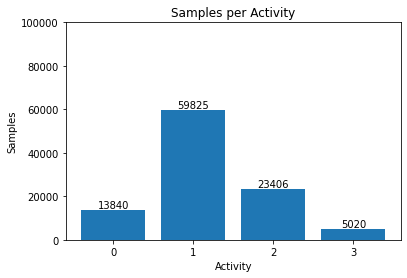

Percentages and count of different activities: 
Activity 0: 13840 - 13% 
Activity 1: 59825 - 58% 
Activity 2: 23406 - 22% 
Activity 3: 5020 - 4% 



In [3]:
from Data import load_dataframes, split_dataframe_by_activity
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("./output/activities/test_data_with_activities.csv")
df_0, df_1, df_2, df_3 = split_dataframe_by_activity(df)

activities = ['0', '1', '2', '3']
act_counts = [len(df_0),len(df_1),len(df_2),len(df_3)]

fig, ax = plt.subplots()
bar_container = ax.bar(activities, act_counts)
ax.set(xlabel='Activity', ylabel='Samples', title='Samples per Activity', ylim=(0, 100000))
ax.bar_label(bar_container)
plt.show()

print(f"Percentages and count of different activities: \n"
      f"Activity 0: {len(df_0)} - {int(len(df_0)/len(df)*100)}% \n"
      f"Activity 1: {len(df_1)} - {int(len(df_1)/len(df)*100)}% \n"
      f"Activity 2: {len(df_2)} - {int(len(df_2)/len(df)*100)}% \n"
      f"Activity 3: {len(df_3)} - {int(len(df_3)/len(df)*100)}% \n")

Compared to the training data this is a difference of:
Activity 0: 7%
Activity 1: 5%
Activity 2: 14%
Activity 3: 3%

The mean and std values of the testdata also looks very similar to the training dataset - no bad suprises!

In [12]:
from sklearn.preprocessing import StandardScaler
from Data import get_SlidingWindow_Dataloader
import pandas as pd

test_data = pd.read_csv("data/testdata.csv")

scaler = StandardScaler()
test_data = scaler.fit_transform(test_data)
test_data[0]

array([-1.453941  , -0.32848596,  0.16780453,  0.66705533, -0.53141222,
       -0.02794411])

In [10]:
scaler.mean_

array([1.95927005e+00, 2.42954237e+00, 8.66737429e+00, 9.48894447e-04,
       1.04416098e-02, 1.30333131e-02])

In [11]:
scaler.var_

array([3.68855895, 7.54840812, 7.22509175, 0.44298161, 0.25932777,
       0.33601527])

## Balance the Dataset
In order to deal with the inbalance in the dataset I implemented different methods to balance.

The first method I implemented is simply expanding the underrepresented activities to roughly match the biggest class. For this I simply appended the data x times on itself.

expand class of 148312 samples by factor 3
expand class of 62529 samples by factor 7
expand class of 50751 samples by factor 9


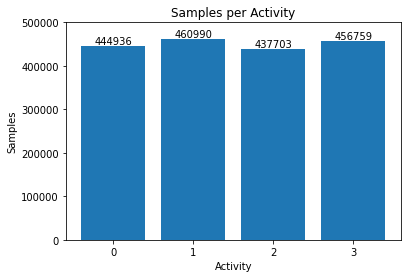

Percentages and count of different activities: 
Activity 0: 444936 - 24% 
Activity 1: 460990 - 25% 
Activity 2: 437703 - 24% 
Activity 3: 456759 - 25% 



In [1]:
import matplotlib.pyplot as plt
from Data import split_dataframe_by_activity, get_balanced_dataset

df_expand_balanced = get_balanced_dataset(method="expand")

df_0, df_1, df_2, df_3 = split_dataframe_by_activity(df_expand_balanced)

activities = ['0', '1', '2', '3']
act_counts = [len(df_0),len(df_1),len(df_2),len(df_3)]

fig, ax = plt.subplots()
bar_container = ax.bar(activities, act_counts)
ax.set(xlabel='Activity', ylabel='Samples', title='Samples per Activity', ylim=(0, 500000))
ax.bar_label(bar_container)
plt.show()

print(f"Percentages and count of different activities: \n"
      f"Activity 0: {len(df_0)} - {int(len(df_0)/len(df_expand_balanced)*100)}% \n"
      f"Activity 1: {len(df_1)} - {int(len(df_1)/len(df_expand_balanced)*100)}% \n"
      f"Activity 2: {len(df_2)} - {int(len(df_2)/len(df_expand_balanced)*100)}% \n"
      f"Activity 3: {len(df_3)} - {int(len(df_3)/len(df_expand_balanced)*100)}% \n")

The simplest method of balancing out was to cut all classes to match the smallest

cut class of 460990 samples down to 50751 samples total
cut class of 148312 samples down to 50751 samples total
cut class of 62529 samples down to 50751 samples total
cut class of 50751 samples down to 50751 samples total


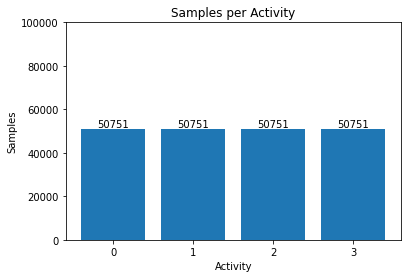

Percentages and count of different activities: 
Activity 0: 50751 - 25% 
Activity 1: 50751 - 25% 
Activity 2: 50751 - 25% 
Activity 3: 50751 - 25% 



In [2]:
import matplotlib.pyplot as plt
from Data import split_dataframe_by_activity, get_balanced_dataset

df_cut_balanced = get_balanced_dataset(method="cut")

df_0, df_1, df_2, df_3 = split_dataframe_by_activity(df_cut_balanced)

activities = ['0', '1', '2', '3']
act_counts = [len(df_0),len(df_1),len(df_2),len(df_3)]

fig, ax = plt.subplots()
bar_container = ax.bar(activities, act_counts)
ax.set(xlabel='Activity', ylabel='Samples', title='Samples per Activity', ylim=(0, 100000))
ax.bar_label(bar_container)
plt.show()

print(f"Percentages and count of different activities: \n"
      f"Activity 0: {len(df_0)} - {int(len(df_0)/len(df_cut_balanced)*100)}% \n"
      f"Activity 1: {len(df_1)} - {int(len(df_1)/len(df_cut_balanced)*100)}% \n"
      f"Activity 2: {len(df_2)} - {int(len(df_2)/len(df_cut_balanced)*100)}% \n"
      f"Activity 3: {len(df_3)} - {int(len(df_3)/len(df_cut_balanced)*100)}% \n")

On my research how to balance datasets I discovered the SMOTE method (synthetic minority oversampling technique) which also extends the minority class. It works by resampling the minority classes based on their distribution. I handled this approach with care because I was not sure if it works good with sequence data.

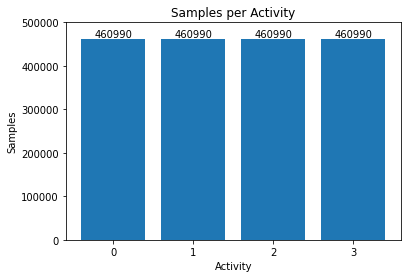

Percentages and count of different activities: 
Activity 0: 460990 - 25% 
Activity 1: 460990 - 25% 
Activity 2: 460990 - 25% 
Activity 3: 460990 - 25% 



In [28]:
import matplotlib.pyplot as plt
from Data import split_dataframe_by_activity, get_balanced_dataset

df_SMOTE_balanced = get_balanced_dataset(method="SMOTE", labels="activity")

df_SMOTE_balanced = df_SMOTE_balanced.rename(columns={'label': ' Activity'}) # needed for below cell

df_0, df_1, df_2, df_3 = split_dataframe_by_activity(df_SMOTE_balanced)

activities = ['0', '1', '2', '3']
act_counts = [len(df_0),len(df_1),len(df_2),len(df_3)]

fig, ax = plt.subplots()
bar_container = ax.bar(activities, act_counts)
ax.set(xlabel='Activity', ylabel='Samples', title='Samples per Activity', ylim=(0, 500000))
ax.bar_label(bar_container)
plt.show()

print(f"Percentages and count of different activities: \n"
      f"Activity 0: {len(df_0)} - {int(len(df_0)/len(df_SMOTE_balanced)*100)}% \n"
      f"Activity 1: {len(df_1)} - {int(len(df_1)/len(df_SMOTE_balanced)*100)}% \n"
      f"Activity 2: {len(df_2)} - {int(len(df_2)/len(df_SMOTE_balanced)*100)}% \n"
      f"Activity 3: {len(df_3)} - {int(len(df_3)/len(df_SMOTE_balanced)*100)}% \n")

Its easily recognisable by the eye where the synthetic samples are appended. Comparing the first 1000 and the last 1000 examples visualizes how the "wave form" is lost by simply sampling from a distribution. Therefore this wont be further utilized but is a good experience for other tasks.

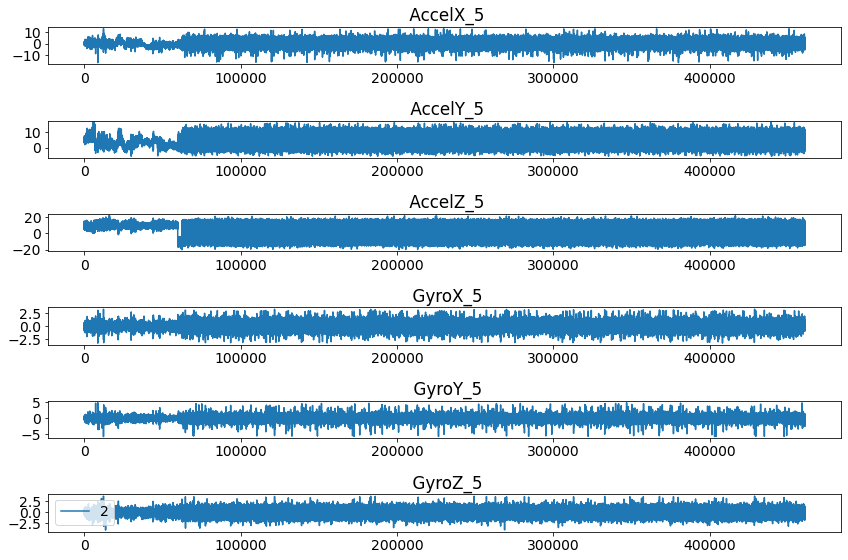

First 1000


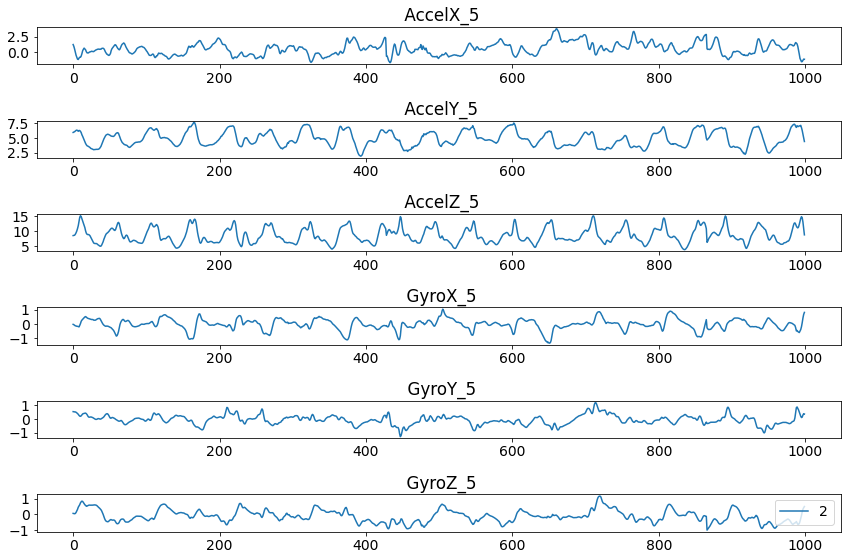

Last 1000


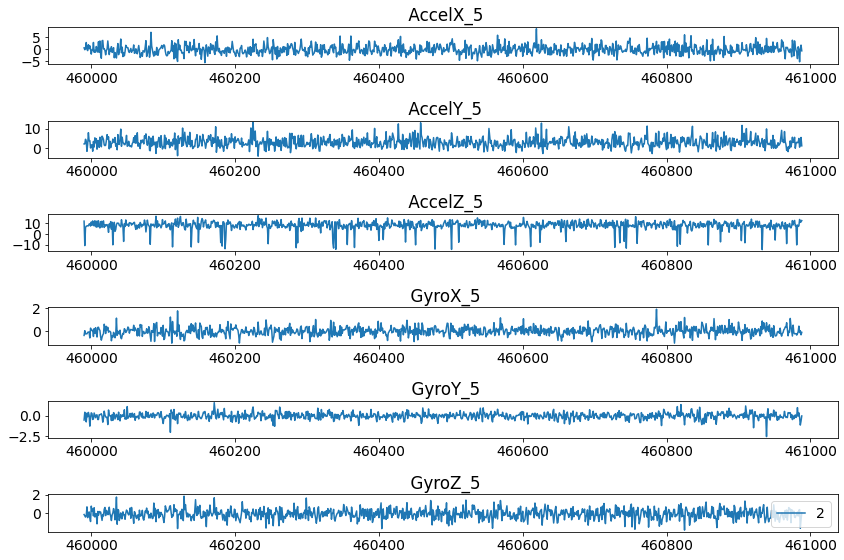

In [30]:
from utils import plot_dataframes

plot_dataframes([df_2], from_sample=0, steps=False)

# check on smaller scale
print("First 1000")
plot_dataframes([df_2], to_sample=1000, steps=False)
print("Last 1000")
plot_dataframes([df_2], from_sample=-1000, steps=False)

Another method that came to my mind was to interpolate in the minority classes. I also did this with caution because the frequency of the "waves" was heavily altered with this.

Add interpolated samples to dataframe of 148312 samples by factor 3
Add interpolated samples to dataframe of 62529 samples by factor 7
Add interpolated samples to dataframe of 50751 samples by factor 9


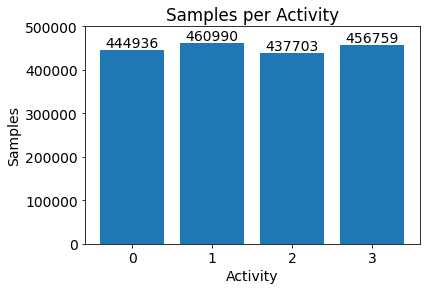

Percentages and count of different activities: 
Activity 0: 444936 - 24% 
Activity 1: 460990 - 25% 
Activity 2: 437703 - 24% 
Activity 3: 456759 - 25% 



In [8]:
from Data import get_balanced_dataset, split_dataframe_by_activity, load_dataframes
import matplotlib.pyplot as plt

df = load_dataframes()
_, _, df_2_unchanged, _ = split_dataframe_by_activity(df)

df_interpolate_balanced = get_balanced_dataset(method="interpolate")

df_0, df_1, df_2, df_3 = split_dataframe_by_activity(df_interpolate_balanced)

activities = ['0', '1', '2', '3']
act_counts = [len(df_0),len(df_1),len(df_2),len(df_3)]

fig, ax = plt.subplots()
bar_container = ax.bar(activities, act_counts)
ax.set(xlabel='Activity', ylabel='Samples', title='Samples per Activity', ylim=(0, 500000))
ax.bar_label(bar_container)
plt.show()

print(f"Percentages and count of different activities: \n"
      f"Activity 0: {len(df_0)} - {int(len(df_0)/len(df_interpolate_balanced)*100)}% \n"
      f"Activity 1: {len(df_1)} - {int(len(df_1)/len(df_interpolate_balanced)*100)}% \n"
      f"Activity 2: {len(df_2)} - {int(len(df_2)/len(df_interpolate_balanced)*100)}% \n"
      f"Activity 3: {len(df_3)} - {int(len(df_3)/len(df_interpolate_balanced)*100)}% \n")

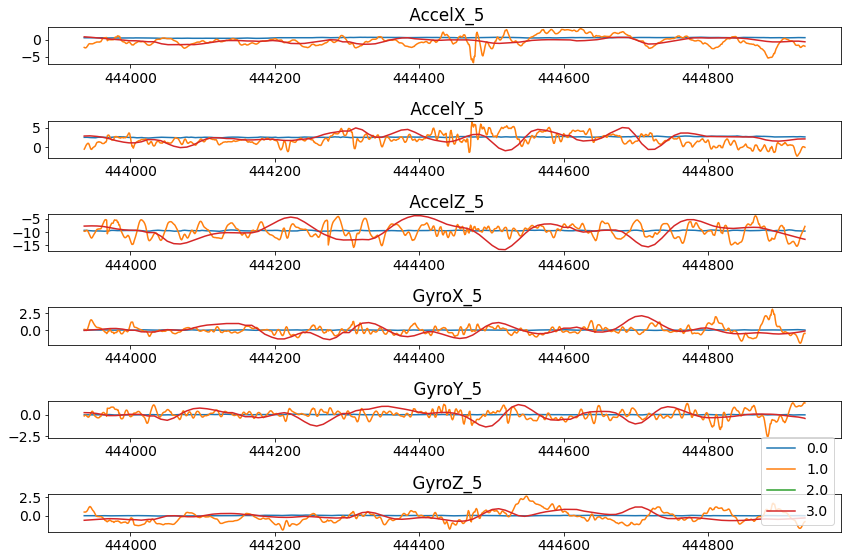

Interpolated Dataframe


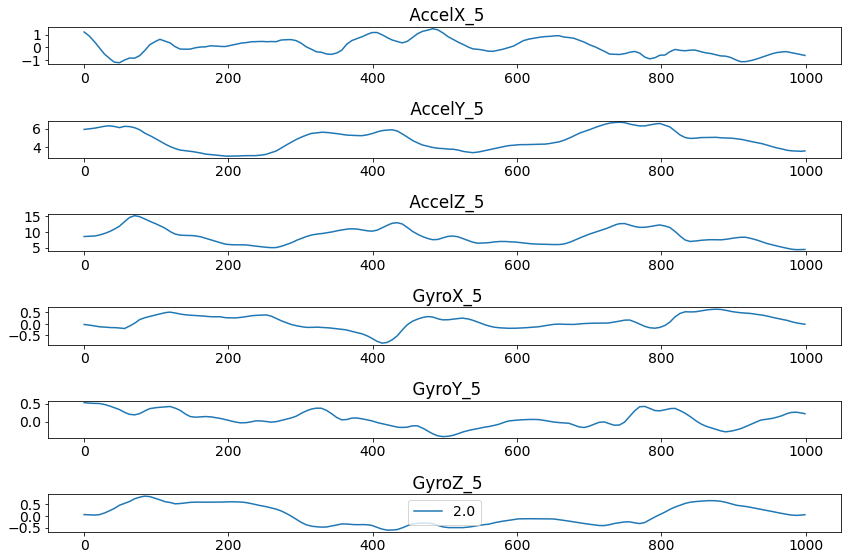

Original Dataframe


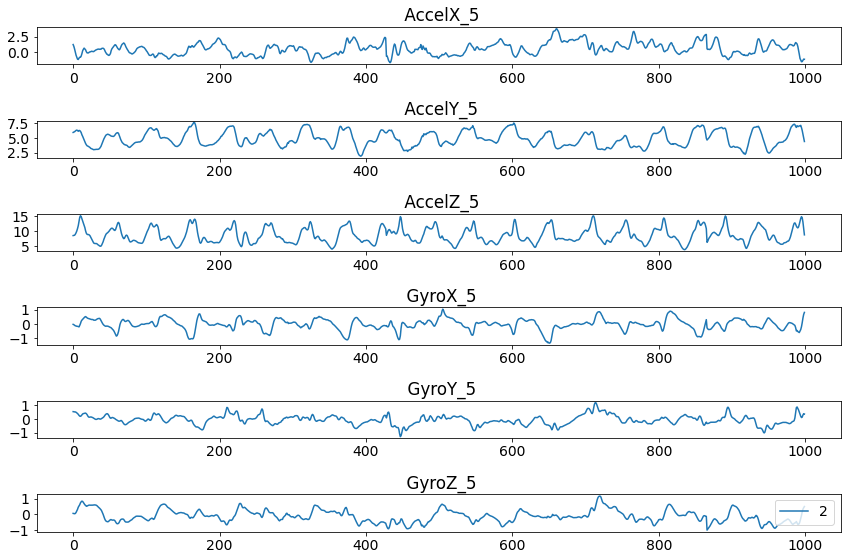

In [9]:
from utils import plot_dataframes

plot_dataframes([df_0, df_1, df_2, df_3], from_sample=-1000, steps=False)

# check on smaller scale
print("Interpolated Dataframe")
plot_dataframes([df_2], to_sample=1000, steps=False)
print("Original Dataframe")
plot_dataframes([df_2_unchanged], to_sample=1000, steps=False)

#### Make Steps continuous

My first idea was to set the start and end columns values all to zero excluding the step indices which are set to 1. With this, I ended up with labels that almost all have the value 0 (> 95%).
As an alternative way, I decided to change the values around the step indizes to be bell-shaped. The step indizes are still with value 1. This way I obtained a Dataset that is continuous but still focused on the step indices.
As the standard deviations I took the value of 10, which is the threshold in which predictions still count as hit.
Implementation can be found in Data.py load_dataframes and make_steps_continuous functions.
Due to a lack of time, I didn´t persued this approach any further.

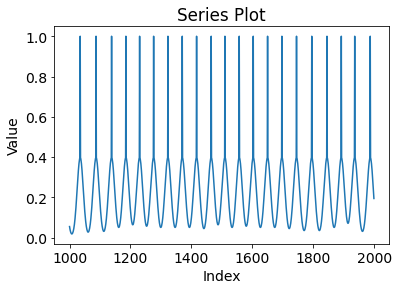

In [10]:
import matplotlib.pyplot as plt
from Data import load_dataframes

series = load_dataframes(steps="countinuous")
series = series["start"]

# Plot the series
plt.plot(series[1000:2000])
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Series Plot')
plt.show()

As an alternative approach for the step detection I wanted to try training an ResNet with fourier transformed data. I was not really sure if this would turn out good but transforming the sequences to a frequency spectrum and performing deep learning on them sounded reasonable to me. For this I first fourier transformed sliding windows of 100 timesteps and appended each of the 6 sensorinputs to each other. Ending up with samples with 600 features seen below.

In [24]:
from sklearn.preprocessing import StandardScaler
from Data import get_SlidingWindow_Dataloader, load_dataframes

scaler = StandardScaler()
df = load_dataframes(labels="activity")

train_dl, _, _ = get_SlidingWindow_Dataloader(df=df,
                                                scaler=scaler,
                                                ordered_df=False,
                                                train_test_split=0.9,
                                                batch_size=128,
                                                shape_for="resnet",
                                                target_index="first")

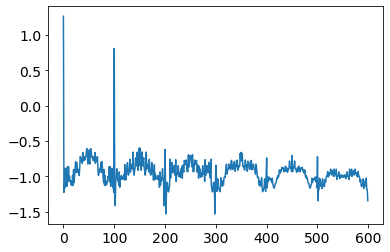

In [25]:
import matplotlib.pyplot as plt

plt.plot(train_dl.dataset[0][0])

The original data as comparison.

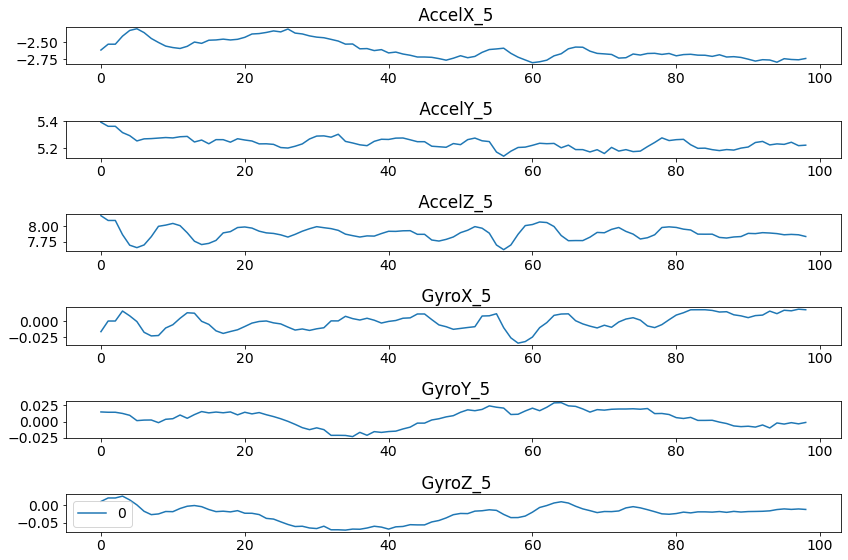

In [26]:
df = df.rename(columns={'label': ' Activity'}) # needed for below cell
plot_dataframes([df.iloc[0:100]])

Continue at Classify_Activities